# Node embedding and downstream tasks

In [1]:
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.svm import LinearSVC

In [2]:
from bluegraph.core import PandasPGFrame
from bluegraph.preprocess.generators import CooccurrenceGenerator
from bluegraph.preprocess.encoders import ScikitLearnPGEncoder

from bluegraph.core.embed.embedders import GraphElementEmbedder
from bluegraph.backends.stellargraph import StellarGraphNodeEmbedder

from bluegraph.downstream import EmbeddingPipeline, transform_to_2d, plot_2d, get_classification_scores
from bluegraph.downstream.similarity import (SimilarityProcessor, NodeSimilarityProcessor)
from bluegraph.downstream.node_classification import NodeClassifier
from bluegraph.downstream.link_prediction import (generate_negative_edges,
                                                  EdgePredictor)

## Data preparation

Fist, we read the source dataset with mentions of entities in different paragraphs

In [3]:
mentions = pd.read_csv("../data/labeled_entity_occurrence.csv")

In [4]:
# Extract unique paper/seciton/paragraph identifiers
mentions = mentions.rename(columns={"occurrence": "paragraph"})
number_of_paragraphs = len(mentions["paragraph"].unique())

In [5]:
mentions

,entity,paragraph
0,lithostathine-1-alpha,1
1,pulmonary,1
2,host,1
3,lithostathine-1-alpha,2
4,surfactant protein d measurement,2
...,...,...
2281346,covid-19,227822
2281347,covid-19,227822
2281348,viral infection,227823
2281349,lipid,227823


We will also load a dataset that contains definitions of entities and their types

In [6]:
entity_data = pd.read_csv("../data/entity_types_defs.csv")

In [7]:
entity_data

,entity,entity_type,definition
0,(e3-independent) e2 ubiquitin-conjugating enzyme,PROTEIN,(E3-independent) E2 ubiquitin-conjugating enzy...
1,(h115d)vhl35 peptide,CHEMICAL,A peptide vaccine derived from the von Hippel-...
2,"1,1-dimethylhydrazine",DRUG,"A clear, colorless, flammable, hygroscopic liq..."
3,"1,2-dimethylhydrazine",CHEMICAL,A compound used experimentally to induce tumor...
4,"1,25-dihydroxyvitamin d(3) 24-hydroxylase, mit...",PROTEIN,"1,25-dihydroxyvitamin D(3) 24-hydroxylase, mit..."
...,...,...,...
28127,zygomycosis,DISEASE,Any infection due to a fungus of the Zygomycot...
28128,zygomycota,ORGANISM,A phylum of fungi that are characterized by ve...
28129,zygosity,ORGANISM,"The genetic condition of a zygote, especially ..."
28130,zygote,CELL_COMPARTMENT,"The cell formed by the union of two gametes, e..."


### Generation of a co-occurrence graph

We first create a graph whose nodes are entities

In [34]:
graph = PandasPGFrame()
entity_nodes = mentions["entity"].unique()
graph.add_nodes(entity_nodes)
graph.add_node_types({n: "Entity" for n in entity_nodes})

entity_props = entity_data.rename(columns={"entity": "@id"}).set_index("@id")
graph.add_node_properties(entity_props["entity_type"], prop_type="category")
graph.add_node_properties(entity_props["definition"], prop_type="text")

In [35]:
paragraph_prop = pd.DataFrame({"paragraphs": mentions.groupby("entity").aggregate(set)["paragraph"]})
graph.add_node_properties(paragraph_prop, prop_type="category")

In [36]:
graph.nodes(raw_frame=True)

,@type,entity_type,definition,paragraphs
@id,,,,
lithostathine-1-alpha,Entity,PROTEIN,"Lithostathine-1-alpha (166 aa, ~19 kDa) is enc...","{1, 2, 3, 18178, 195589, 104454, 88967, 104455..."
pulmonary,Entity,ORGAN,Relating to the lungs as the intended site of ...,"{1, 196612, 196613, 196614, 196621, 196623, 16..."
host,Entity,ORGANISM,An organism that nourishes and supports anothe...,"{1, 114689, 3, 221193, 180243, 180247, 28, 180..."
surfactant protein d measurement,Entity,PROTEIN,The determination of the amount of surfactant ...,"{145537, 2, 3, 4, 5, 6, 51202, 103939, 103940,..."
communication response,Entity,PATHWAY,A statement (either spoken or written) that is...,"{46592, 64000, 2, 28162, 166912, 226304, 88585..."
...,...,...,...,...
drug binding site,Entity,PATHWAY,The reactive parts of a macromolecule that dir...,"{225082, 225079}"
carbaril,Entity,CHEMICAL,A synthetic carbamate acetylcholinesterase inh...,"{225408, 225409, 225415, 225419, 225397}"
ny-eso-1 positive tumor cells present,Entity,CELL_TYPE,An indication that Cancer/Testis Antigen 1 exp...,"{225544, 226996}"


For each node we will add the `frequency` property that counts the total number of paragraphs where the entity was mentioned.

In [37]:
frequencies = graph._nodes["paragraphs"].apply(len)
frequencies.name = "frequency"
graph.add_node_properties(frequencies)

In [38]:
graph.nodes(raw_frame=True)

,@type,entity_type,definition,paragraphs,frequency
@id,,,,,
lithostathine-1-alpha,Entity,PROTEIN,"Lithostathine-1-alpha (166 aa, ~19 kDa) is enc...","{1, 2, 3, 18178, 195589, 104454, 88967, 104455...",80
pulmonary,Entity,ORGAN,Relating to the lungs as the intended site of ...,"{1, 196612, 196613, 196614, 196621, 196623, 16...",8295
host,Entity,ORGANISM,An organism that nourishes and supports anothe...,"{1, 114689, 3, 221193, 180243, 180247, 28, 180...",2660
surfactant protein d measurement,Entity,PROTEIN,The determination of the amount of surfactant ...,"{145537, 2, 3, 4, 5, 6, 51202, 103939, 103940,...",268
communication response,Entity,PATHWAY,A statement (either spoken or written) that is...,"{46592, 64000, 2, 28162, 166912, 226304, 88585...",160
...,...,...,...,...,...
drug binding site,Entity,PATHWAY,The reactive parts of a macromolecule that dir...,"{225082, 225079}",2
carbaril,Entity,CHEMICAL,A synthetic carbamate acetylcholinesterase inh...,"{225408, 225409, 225415, 225419, 225397}",5
ny-eso-1 positive tumor cells present,Entity,CELL_TYPE,An indication that Cancer/Testis Antigen 1 exp...,"{225544, 226996}",2


Now, for constructing co-occurrence network we will select only 1000 most frequent entities.

In [39]:
nodes_to_include = graph._nodes.nlargest(1000, "frequency").index

In [40]:
nodes_to_include

Index(['covid-19', 'blood', 'human', 'infectious disorder', 'heart',
       'diabetes mellitus', 'lung', 'sars-cov-2', 'mouse', 'pulmonary',
       ...
       'wheezing', 'chief complaint', 'azathioprine', 'ileum', 'hematology',
       'nonalcoholic steatohepatitis', 'nervous system disorder',
       'renal impairment', 'urticaria', 'rectum'],
      dtype='object', name='@id', length=1000)

The `CooccurrenceGenerator` class allows us to generate co-occurrence edges from overlaps in node property values or edge (or edge properties). In this case we consider the `paragraph` node property and construct co-occurrence edges from overlapping sets of paragraphs. In addition, we will compute some co-occurrence statistics: total co-occurrence frequency and normalized pointwise mutual information (NPMI).

In [15]:
%%time
generator = CooccurrenceGenerator(graph.subgraph(nodes=nodes_to_include))
paragraph_cooccurrence_edges = generator.generate_from_nodes(
    "paragraphs", total_factor_instances=number_of_paragraphs,
    compute_statistics=["frequency", "npmi"],
    parallelize=True, cores=8)

Examining 499500 pairs of terms for co-occurrence...
CPU times: user 8.11 s, sys: 2.4 s, total: 10.5 s
Wall time: 1min 29s


In [16]:
cutoff = paragraph_cooccurrence_edges["npmi"].mean()

In [17]:
paragraph_cooccurrence_edges = paragraph_cooccurrence_edges[paragraph_cooccurrence_edges["npmi"] > cutoff]

We add generated edges to the original graph

In [41]:
graph._edges = paragraph_cooccurrence_edges
graph.edge_prop_as_numeric("frequency")
graph.edge_prop_as_numeric("npmi")

In [42]:
graph.edges(raw_frame=True)

common_factors  \
@source_id                        @target_id                                                                              
surfactant protein d measurement  microorganism                       {2, 3, 7810, 58, 41, 7754, 7850, 26218, 7853, ...   
                                  lung                                {2, 103939, 51202, 5, 4, 103940, 15, 145438, 3...   
                                  alveolar                            {223872, 2, 51202, 100502, 7831, 149657, 19522...   
                                  epithelial cell                     {2, 4, 5, 222298, 7825, 7732, 7733, 169174, 7738}   
                                  molecule                            {2, 7750, 49991, 134504, 206448, 49, 52, 20645...   
...                                                                                                                 ...   
chloroquine                       caax prenyl protease 2                               {201001, 205345, 225292, 198655}   
                                  transmembrane protease serine 2     {168961, 221923, 193191, 201001, 204972, 19044...   
severe acute respiratory syndrome ciliated bronchial epithelial cell                           {192152, 167301, 188166}   
                                  caax prenyl protease 2                       {205345, 185829, 227486, 220124, 220126}   
                                  transmembrane protease serine 2     {223746, 223747, 167301, 223752, 200971, 22375...   

                                                                      frequency  \
@source_id                        @target_id                                      
surfactant protein d measurement  microorganism                              19   
                                  lung                                       93   
                                  alveolar                                   25   
                                  epithelial cell                             9   
                                  molecule                                   10   
...                                                                         ...   
chloroquine                       caax prenyl protease 2                      4   
                                  transmembrane protease serine 2            19   
severe acute respiratory syndrome ciliated bronchial epithelial cell          3   
                                  caax prenyl protease 2                      5   
                                  transmembrane protease serine 2            21   

                                                                          npmi  
@source_id                        @target_id                                    
surfactant protein d measurement  microorganism                       0.235263  
                                  lung                                0.221395  
                                  alveolar                            0.336175  
                                  epithelial cell                     0.175923  
                                  molecule                            0.113611  
...                                                                        ...  
chloroquine                       caax prenyl protease 2              0.159462  
                                  transmembrane protease serine 2     0.271910  
severe acute respiratory syndrome ciliated bronchial epithelial cell  0.089285  
                                  caax prenyl protease 2              0.142611  
                                  transmembrane protease serine 2     0.238160  

[161332 rows x 3 columns]

Recall that we have generated edges only for the 1000 most frequent entities, the rest of the entities will be isolated (having no incident edges). Let us remove all the isolated nodes.

In [43]:
graph.remove_node_properties("paragraphs")
graph.remove_edge_properties("common_factors")

In [44]:
graph.remove_isolated_nodes()

In [45]:
graph.number_of_nodes()

1000

Next, we save the generated co-occurrence graph.

In [46]:
graph.export_json("../data/cooccurrence_graph.json")

In [47]:
graph = PandasPGFrame.load_json("../data/cooccurrence_graph.json")

### Node feature extraction

We extract node features from entity definitions using the `tfidf` model.

In [48]:
encoder = ScikitLearnPGEncoder(
    node_properties=["definition"],
    text_encoding_max_dimension=512)

In [49]:
%%time
transformed_graph = encoder.fit_transform(graph)

CPU times: user 805 ms, sys: 22.1 ms, total: 827 ms
Wall time: 841 ms


We can have a glance at the vocabulary that the encoder constructed for the 'definition' property

In [50]:
vocabulary = encoder._node_encoders["definition"].vocabulary_
list(vocabulary.keys())[:10]

['relating',
 'lungs',
 'site',
 'administration',
 'product',
 'usually',
 'action',
 'lower',
 'respiratory',
 'tract']

We will add additional properties to our transformed graph corresponding to the entity type labels. We will also add NPMI as an edge property to this transformed graph.

In [51]:
transformed_graph.add_node_properties(
    graph.get_node_property_values("entity_type"))
transformed_graph.add_edge_properties(
    graph.get_edge_property_values("npmi"), prop_type="numeric")

In [52]:
transformed_graph.nodes(raw_frame=True)

,features,@type,entity_type
@id,,,
pulmonary,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Entity,ORGAN
host,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Entity,ORGANISM
surfactant protein d measurement,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Entity,PROTEIN
microorganism,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Entity,ORGANISM
lung,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Entity,ORGAN
...,...,...,...
candida parapsilosis,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Entity,ORGANISM
ciliated bronchial epithelial cell,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Entity,CELL_TYPE
cystic fibrosis pulmonary exacerbation,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Entity,DISEASE


## Node embedding and downstream tasks

### Node embedding using StellarGraph

Using `StellarGraphNodeEmbedder` we construct three different embeddings of our transformed graph corresponding to different embedding techniques.

In [53]:
node2vec_embedder = StellarGraphNodeEmbedder(
    "node2vec", edge_weight="npmi", embedding_dimension=64, length=10, number_of_walks=20)
node2vec_embedding = node2vec_embedder.fit_model(transformed_graph)

In [54]:
attri2vec_embedder = StellarGraphNodeEmbedder(
    "attri2vec", feature_vector_prop="features",
    length=5, number_of_walks=10,
    epochs=10, embedding_dimension=128, edge_weight="npmi")
attri2vec_embedding = attri2vec_embedder.fit_model(transformed_graph)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [55]:
gcn_dgi_embedder = StellarGraphNodeEmbedder(
    "gcn_dgi", feature_vector_prop="features", epochs=250, embedding_dimension=512)
gcn_dgi_embedding = gcn_dgi_embedder.fit_model(transformed_graph)

Using GCN (local pooling) filters...


The `fit_model` method produces a dataframe of the following shape

In [56]:
node2vec_embedding

,embedding
pulmonary,"[0.1801830679178238, 0.3929305672645569, 0.198..."
host,"[0.060145918279886246, -0.05551265552639961, -..."
surfactant protein d measurement,"[0.17226189374923706, 0.011942804791033268, -0..."
microorganism,"[0.06880081444978714, 0.32872387766838074, -0...."
lung,"[0.13371682167053223, 0.07914051413536072, -0...."
...,...
candida parapsilosis,"[0.07370975613594055, 0.4943331778049469, -0.2..."
ciliated bronchial epithelial cell,"[0.15771272778511047, -0.09300029277801514, -0..."
cystic fibrosis pulmonary exacerbation,"[0.1341496706008911, 0.29923954606056213, -0.0..."
caax prenyl protease 2,"[0.20857787132263184, 0.03755573555827141, 0.0..."


Let us add the embedding vectors obtained using different models as node properties of our graph.

In [57]:
transformed_graph.add_node_properties(
    node2vec_embedding.rename(columns={"embedding": "node2vec"}))

In [58]:
transformed_graph.add_node_properties(
    attri2vec_embedding.rename(columns={"embedding": "attri2vec"}))

In [59]:
transformed_graph.add_node_properties(
    gcn_dgi_embedding.rename(columns={"embedding": "gcn_dgi"}))

In [60]:
transformed_graph.nodes(raw_frame=True)

,features,@type,entity_type,node2vec,attri2vec,gcn_dgi
@id,,,,,,
pulmonary,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Entity,ORGAN,"[0.1801830679178238, 0.3929305672645569, 0.198...","[0.020502328872680664, 0.011069327592849731, 0...","[0.023664020001888275, 0.0, 0.0, 0.0, 0.001591..."
host,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Entity,ORGANISM,"[0.060145918279886246, -0.05551265552639961, -...","[0.037976622581481934, 0.028499186038970947, 0...","[0.02719019539654255, 0.010195450857281685, 0...."
surfactant protein d measurement,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Entity,PROTEIN,"[0.17226189374923706, 0.011942804791033268, -0...","[0.029654890298843384, 0.02496609091758728, 0....","[0.021299853920936584, 0.013082973659038544, 0..."
microorganism,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Entity,ORGANISM,"[0.06880081444978714, 0.32872387766838074, -0....","[0.11167639493942261, 0.06078648567199707, 0.2...","[0.03296130150556564, 0.0, 0.0, 0.011519476771..."
lung,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Entity,ORGAN,"[0.13371682167053223, 0.07914051413536072, -0....","[0.016595691442489624, 0.016077935695648193, 0...","[0.02340507134795189, 0.011271486058831215, 0...."
...,...,...,...,...,...,...
candida parapsilosis,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Entity,ORGANISM,"[0.07370975613594055, 0.4943331778049469, -0.2...","[0.27667391300201416, 0.12356895208358765, 0.5...","[0.02795989252626896, 0.0, 0.0, 0.015866044908..."
ciliated bronchial epithelial cell,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Entity,CELL_TYPE,"[0.15771272778511047, -0.09300029277801514, -0...","[0.01679292321205139, 0.010268598794937134, 0....","[0.022104518488049507, 0.014455460011959076, 0..."
cystic fibrosis pulmonary exacerbation,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Entity,DISEASE,"[0.1341496706008911, 0.29923954606056213, -0.0...","[0.1478649377822876, 0.05661603808403015, 0.15...","[0.02320319041609764, 0.0, 0.0, 0.0, 0.0, 0.00..."


### Plotting the embeddings

Having produced the embedding vectors, we can project them into a 2D space using dimensionality reduction techniques such as TSNE (t-distributed Stochastic Neighbor Embedding).

In [61]:
node2vec_2d = transform_to_2d(transformed_graph._nodes["node2vec"].tolist())

In [62]:
attri2vec_2d = transform_to_2d(transformed_graph._nodes["attri2vec"].tolist())

In [63]:
gcn_dgi_2d = transform_to_2d(transformed_graph._nodes["gcn_dgi"].tolist())

We can now plot these 2D vectors using the `plot_2d` util provided by `bluegraph`.

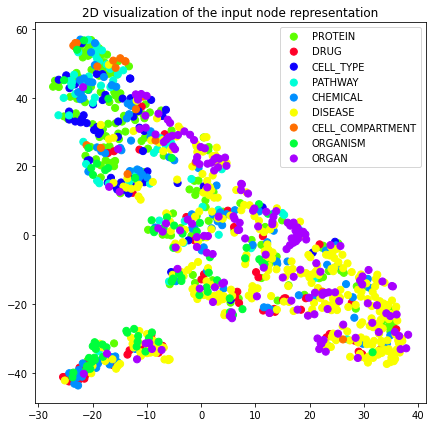

In [64]:
plot_2d(transformed_graph, vectors=node2vec_2d, label_prop="entity_type")

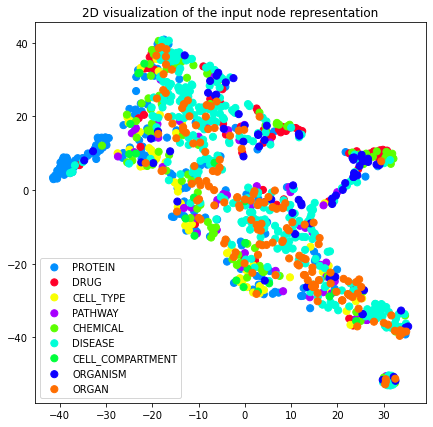

In [65]:
plot_2d(transformed_graph, vectors=attri2vec_2d, label_prop="entity_type")

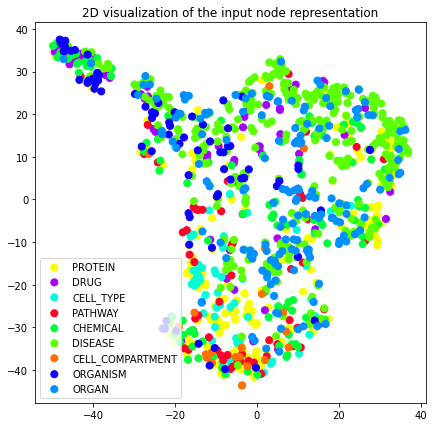

In [66]:
plot_2d(transformed_graph, vectors=gcn_dgi_2d, label_prop="entity_type")

### Node similarity

We would like to be able to search for similar nodes using the computed vector embeddings. For this we can use the `NodeSimilarityProcessor` interfaces provided as a part of `bluegraph`.

We construct similarity processors for different embeddings and query top 10 most similar nodes to the terms `glucose` and `covid-19`.

In [67]:
node2vec_l2 = NodeSimilarityProcessor(transformed_graph, "node2vec", similarity="euclidean")
node2vec_cosine = NodeSimilarityProcessor(
    transformed_graph, "node2vec", similarity="cosine")

In [68]:
node2vec_l2.get_similar_nodes(["glucose", "covid-19"], k=10)

{'glucose': {'glucose': 0.0,
  'nonalcoholic fatty liver disease': 0.012774223,
  'high density lipoprotein': 0.020684605,
  'alanine': 0.023542767,
  'glyburide': 0.02620839,
  'metabolic syndrome': 0.02815028,
  'renin': 0.02943663,
  'nonalcoholic steatohepatitis': 0.03355046,
  'metabolic disorder': 0.036358446,
  'diabetic nephropathy': 0.04033222},
 'covid-19': {'covid-19': 0.0,
  'coronavirus': 0.010350952,
  'fatal': 0.02114112,
  'acute respiratory distress syndrome': 0.05360526,
  'angiotensin ii receptor antagonist': 0.066189155,
  'ace inhibitor': 0.106403425,
  'gas exchanger device': 0.11095005,
  'person': 0.115802094,
  'middle east respiratory syndrome': 0.12268625,
  'hydroxychloroquine': 0.12845182}}

In [69]:
node2vec_cosine.get_similar_nodes(["glucose", "covid-19"], k=10)

{'glucose': {'glucose': 0.99999994,
  'nonalcoholic fatty liver disease': 0.9976926,
  'high density lipoprotein': 0.9959981,
  'metabolic syndrome': 0.9957851,
  'alanine': 0.995212,
  'glyburide': 0.99469495,
  'renin': 0.9942713,
  'nonalcoholic steatohepatitis': 0.99340194,
  'metabolic disorder': 0.99325126,
  'diabetic nephropathy': 0.9919394},
 'covid-19': {'covid-19': 1.0000001,
  'coronavirus': 0.9977423,
  'fatal': 0.9958515,
  'acute respiratory distress syndrome': 0.98975295,
  'angiotensin ii receptor antagonist': 0.98549634,
  'ace inhibitor': 0.97691953,
  'gas exchanger device': 0.97561,
  'hydroxychloroquine': 0.9749321,
  'middle east respiratory syndrome': 0.97482693,
  'person': 0.97478867}}

In [70]:
attri2vec_l2 = NodeSimilarityProcessor(transformed_graph, "attri2vec")
attri2vec_cosine = NodeSimilarityProcessor(
    transformed_graph, "attri2vec", similarity="cosine")

In [71]:
attri2vec_l2.get_similar_nodes(["glucose", "covid-19"], k=10)

{'glucose': {'glucose': 0.0,
  'hemoglobin': 0.011370808,
  'axon': 0.011814589,
  'pelvis': 0.012231074,
  'vitamin': 0.013574594,
  'bile': 0.013575361,
  'digestion': 0.014175085,
  'blood clot': 0.014205426,
  'autosome': 0.014388764,
  'placenta': 0.01500852},
 'covid-19': {'covid-19': 0.0,
  'pleural effusion': 0.00032892267,
  'pulmonary edema': 0.0003433606,
  'vasculitis': 0.00052991934,
  'anemia': 0.00075252884,
  'osteoporosis': 0.000840844,
  'h1n1 influenza': 0.00085218134,
  'inflammatory disorder': 0.0008828577,
  'respiratory failure': 0.00089213636,
  'interleukin-1': 0.0009075226}}

In [72]:
attri2vec_cosine.get_similar_nodes(["glucose", "covid-19"], k=10)

{'glucose': {'glucose': 0.99999994,
  'dehydration': 0.97696567,
  'saline': 0.97321284,
  'hemoglobin': 0.97301006,
  'graft versus host disease': 0.97118986,
  'human': 0.9708272,
  'degradation': 0.9704817,
  'acid': 0.9704014,
  'formation': 0.97016114,
  'axon': 0.96873516},
 'covid-19': {'covid-19': 1.0,
  'h1n1 influenza': 0.98213583,
  'viral respiratory tract infection': 0.9820816,
  'septicemia': 0.9819951,
  'childhood-onset systemic lupus erythematosus': 0.98162067,
  'middle east respiratory syndrome': 0.98151916,
  'severe acute respiratory syndrome': 0.98125625,
  'dengue fever': 0.97564375,
  'upper respiratory tract infection': 0.97534525,
  'have chronic infection': 0.9687631}}

In [73]:
gcn_l2 = NodeSimilarityProcessor(transformed_graph, "gcn_dgi")
gcn_cosine = NodeSimilarityProcessor(
    transformed_graph, "gcn_dgi", similarity="cosine")

In [74]:
gcn_l2.get_similar_nodes(["glucose", "covid-19"], k=10)

{'glucose': {'glucose': 0.0,
  'glucose tolerance test': 0.0028574471,
  'triglycerides': 0.0032473956,
  'high density lipoprotein': 0.0032524616,
  'insulin': 0.0033432455,
  'cholesterol': 0.0051594405,
  'uric acid': 0.005844086,
  'diabetic nephropathy': 0.0060125683,
  'low density lipoprotein': 0.0062707127,
  'organic phosphate': 0.0063460045},
 'covid-19': {'covid-19': 0.0,
  'coronavirus': 0.0010822312,
  'fatal': 0.0022906482,
  'acute respiratory distress syndrome': 0.0024724875,
  'myocarditis': 0.0040092813,
  'angiotensin ii receptor antagonist': 0.004444811,
  'cardiac valve injury': 0.004826556,
  'sars-cov-2': 0.005557484,
  'ace inhibitor': 0.005761604,
  'severe acute respiratory syndrome': 0.005834179}}

In [75]:
gcn_cosine.get_similar_nodes(["glucose", "covid-19"], k=10)

{'glucose': {'glucose': 1.0,
  'triglycerides': 0.9831724,
  'insulin': 0.98218644,
  'glucose tolerance test': 0.9813399,
  'high density lipoprotein': 0.98037225,
  'cholesterol': 0.9786337,
  'low density lipoprotein': 0.972376,
  'glomerulus': 0.9672339,
  'plasma': 0.9664898,
  'diabetic nephropathy': 0.964558},
 'covid-19': {'covid-19': 1.0,
  'coronavirus': 0.99503505,
  'fatal': 0.9901831,
  'acute respiratory distress syndrome': 0.98841774,
  'myocarditis': 0.98117304,
  'angiotensin ii receptor antagonist': 0.980951,
  'cardiac valve injury': 0.9777557,
  'sars-cov-2': 0.9756447,
  'ace inhibitor': 0.9746202,
  'severe acute respiratory syndrome': 0.97441816}}

### Node clustering

We can cluster nodes according to their node embeddings. Often such clustering helps to reveal the community structure encoded in the underlying networks.

In this example we will use the `BayesianGaussianMixture` model provided by the scikit-learn to cluster the nodes according to different embeddings into 5 clusters.

In [76]:
from sklearn import mixture

In [77]:
N = 5

In [78]:
X = transformed_graph.get_node_property_values("node2vec").to_list()
gmm = mixture.BayesianGaussianMixture(n_components=N, covariance_type='full').fit(X)
node2vec_clusters = gmm.predict(X)

In [79]:
X = transformed_graph.get_node_property_values("attri2vec").to_list()
gmm = mixture.BayesianGaussianMixture(n_components=5, covariance_type='full').fit(X)
attri2vec_clusters = gmm.predict(X)

In [80]:
X = transformed_graph.get_node_property_values("gcn_dgi").to_list()
gmm = mixture.BayesianGaussianMixture(n_components=5, covariance_type='full').fit(X)
gcn_dgi_clusters = gmm.predict(X)

Below we inspect the most frequent cluster members.

In [81]:
def show_top_members(clusters, N):
    for i in range(N):
        df = transformed_graph._nodes.iloc[np.where(clusters == i)]
        df.loc[:, "frequency"] = df.index.map(lambda x: graph._nodes.loc[x, "frequency"])
        print(f"#{i}: ", ", ".join(df.nlargest(10, columns=["frequency"]).index))

In [82]:
show_top_members(node2vec_clusters, N)

#0:  blood, heart, pulmonary, death, renal, hypertension, cardiovascular system, oral cavity, fever, injury
#1:  survival, inflammation, virus, glucose, cancer, obesity, plasma, angiotensin-converting enzyme 2, interleukin-6, sars coronavirus
#2:  human, mouse, animal, cytokine, dna, proliferation, lipid, tumor necrosis factor, t-lymphocyte, apoptosis
#3:  infectious disorder, bacteria, antibiotic, respiratory system, pneumonia, escherichia coli, staphylococcus aureus, pathogen, klebsiella pneumoniae, microorganism
#4:  covid-19, diabetes mellitus, lung, sars-cov-2, liver, brain, kidney, serum, dog, person


/Users/oshurko/opt/anaconda3/envs/bluegraph/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/oshurko/opt/anaconda3/envs/bluegraph/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [83]:
show_top_members(attri2vec_clusters, N)

#0:  human, renal, survival, hypertension, oral cavity, injury, oxygen, airway, neutrophil, muscle
#1:  dog, cat, water, depression, horse, anxiety, nasal, subarachnoid hemorrhage, proximal, brother
#2:  infectious disorder, diabetes mellitus, lung, sars-cov-2, mouse, pulmonary, bacteria, liver, virus, animal
#3:  covid-19, blood, heart, inflammation, antibiotic, organ, sars coronavirus, pneumonia, cystic fibrosis, staphylococcus aureus
#4:  death, person, urine, proliferation, molecule, pain, lower, failure, intestinal, transfer


In [84]:
show_top_members(gcn_dgi_clusters, N)

#0:  infectious disorder, respiratory system, oral cavity, pneumonia, skin, fever, cystic fibrosis, urine, human immunodeficiency virus, influenza
#1:  bacteria, antibiotic, escherichia coli, staphylococcus aureus, pathogen, klebsiella pneumoniae, microorganism, mucoid pseudomonas aeruginosa, organism, sputum
#2:  human, mouse, inflammation, animal, cytokine, plasma, interleukin-6, neoplasm, dna, neutrophil
#3:  covid-19, blood, heart, diabetes mellitus, pulmonary, death, renal, hypertension, cardiovascular system, dog
#4:  lung, sars-cov-2, liver, survival, virus, brain, glucose, kidney, cancer, serum


We can also use the previously `plot_2d` util and color our 2D nore representation according to the clusters they belong to.

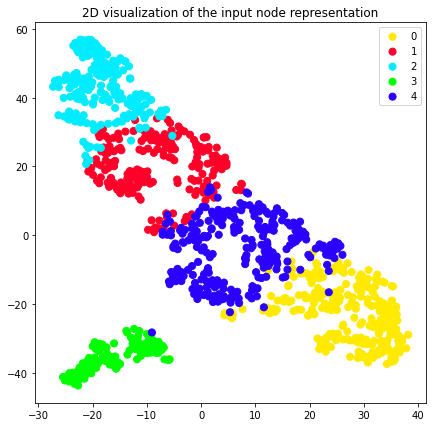

In [85]:
plot_2d(transformed_graph, vectors=node2vec_2d, labels=node2vec_clusters)

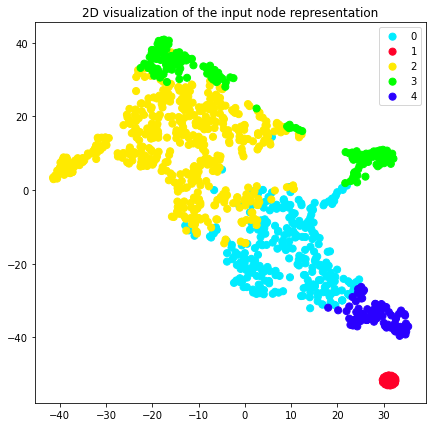

In [86]:
plot_2d(transformed_graph, vectors=attri2vec_2d, labels=attri2vec_clusters)

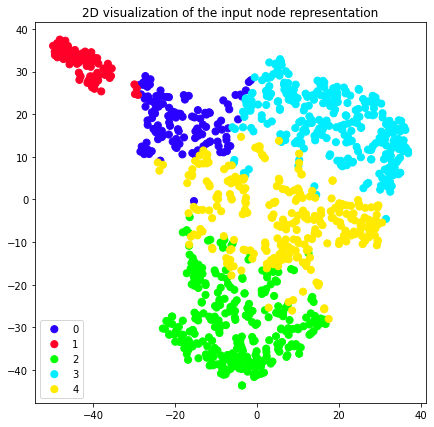

In [87]:
plot_2d(transformed_graph, vectors=gcn_dgi_2d, labels=gcn_dgi_clusters)

### Node classification

Another downstream task that we would like to perform is node classification. We would like to automatically assign entity types according to their node embeddings. For this we will build predictive models for entity type prediction based on:

- Only node features
- Node2vec embeddings (only structure)
- Attri2vec embeddings (structure and node features)
- GCN Deep Graph Infomax embeddings (structure and node features)

First of all, we split the graph nodes into the train and the test sets.

In [88]:
train_nodes, test_nodes = model_selection.train_test_split(
    transformed_graph.nodes(), train_size=0.8)

Now we use the `NodeClassifier` interface to create our classification models. As the base model we will use the linear SVM classifier (`LinearSVC`) provided by `scikit-learn`.

In [89]:
features_classifier = NodeClassifier(LinearSVC(), feature_vector_prop="features")
features_classifier.fit(transformed_graph, train_elements=train_nodes, label_prop="entity_type")
features_pred = features_classifier.predict(transformed_graph, predict_elements=test_nodes)

In [90]:
node2vec_classifier = NodeClassifier(LinearSVC(), feature_vector_prop="node2vec")
node2vec_classifier.fit(transformed_graph, train_elements=train_nodes, label_prop="entity_type")
node2vec_pred = node2vec_classifier.predict(transformed_graph, predict_elements=test_nodes)

In [91]:
attri2vec_classifier = NodeClassifier(LinearSVC(), feature_vector_prop="attri2vec")
attri2vec_classifier.fit(transformed_graph, train_elements=train_nodes, label_prop="entity_type")
attri2vec_pred = attri2vec_classifier.predict(transformed_graph, predict_elements=test_nodes)

/Users/oshurko/opt/anaconda3/envs/bluegraph/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [92]:
gcn_dgi_classifier = NodeClassifier(LinearSVC(), feature_vector_prop="gcn_dgi")
gcn_dgi_classifier.fit(transformed_graph, train_elements=train_nodes, label_prop="entity_type")
gcn_dgi_pred = gcn_dgi_classifier.predict(transformed_graph, predict_elements=test_nodes)

Let us have a look at the scores of different node classification models we have produced.

In [93]:
true_labels = transformed_graph._nodes.loc[test_nodes, "entity_type"]

In [94]:
get_classification_scores(true_labels, features_pred, multiclass=True)

{'accuracy': 0.605,
 'precision': 0.605,
 'recall': 0.605,
 'f1_score': 0.605,
 'roc_auc_score': 0.7956721047970554}

In [95]:
get_classification_scores(true_labels, node2vec_pred, multiclass=True)

{'accuracy': 0.41,
 'precision': 0.41,
 'recall': 0.41,
 'f1_score': 0.41,
 'roc_auc_score': 0.7164664267541682}

In [96]:
get_classification_scores(true_labels, attri2vec_pred, multiclass=True)

{'accuracy': 0.5,
 'precision': 0.5,
 'recall': 0.5,
 'f1_score': 0.5,
 'roc_auc_score': 0.7459642741964382}

In [97]:
get_classification_scores(true_labels, gcn_dgi_pred, multiclass=True)

{'accuracy': 0.395,
 'precision': 0.395,
 'recall': 0.395,
 'f1_score': 0.395,
 'roc_auc_score': 0.7022502034819732}

## Link prediction

Finally, we would like to use the produced node embeddings to predict the existance of edges. This downstream task is formulated as follows: given a pair of nodes and their embedding vectors, is there an edge between these nodes?

As the first step of the edges prediciton task we will generate false edges for training (node pairs that don't have edges between them).

In [98]:
false_edges = generate_negative_edges(transformed_graph)

We will now split both true and false edges into training and test sets.

In [99]:
true_train_edges, true_test_edges = model_selection.train_test_split(
    transformed_graph.edges(), train_size=0.8)

In [100]:
false_train_edges, false_test_edges = model_selection.train_test_split(
    false_edges, train_size=0.8)

And, finally, we will use the `EdgePredictor` interface to build our model (using `LinearSVC` as before and the Hadamard product as the binary operator between the embedding vectors for the source and the target nodes.

In [ ]:
model = EdgePredictor(LinearSVC(), feature_vector_prop="node2vec",
                      operator="hadamard", directed=False)
model.fit(transformed_graph, true_train_edges, negative_samples=false_train_edges)

In [ ]:
true_labels = np.hstack([
    np.ones(len(true_test_edges)),
    np.zeros(len(false_test_edges))])

In [ ]:
y_pred = model.predict(transformed_graph, true_test_edges + false_test_edges)

Let us have a look at the obtained scores.

In [ ]:
get_classification_scores(true_labels, y_pred)

## Creating and saving embedding pipelines

`bluegraph` allows to create emebedding pipelines (using the `EmbeddingPipeline` class) that represent a useful wrapper around a sequence of steps necessary to produce embeddings and compute point similarities. In the example below we create a pipeline for producing `attri2vec` node embeddings and computing their cosine similarity.

We first create an encoder object that will be used in our pipeline as a preprocessing step.

In [ ]:
definition_encoder = ScikitLearnPGEncoder(
    node_properties=["definition"], text_encoding_max_dimension=512)

We then create an embedder object.

In [ ]:
D = 128
params = {
    "length": 5,
    "number_of_walks": 10,
    "epochs": 5,
    "embedding_dimension": D
}
attri2vec_embedder = StellarGraphNodeEmbedder(
    "attri2vec", feature_vector_prop="features", edge_weight="npmi", **params)

And finally we create a pipeline object. Note that in the code below we use the `SimilarityProcessor` interface and not `NodeSimilarityProcessor`, as we have done it previously. We use this lower abstraction level interface, because the `EmbeddingPipeline` is designed to work with any embedding models (not only node embedding models).

In [ ]:
attri2vec_pipeline = EmbeddingPipeline(
    preprocessor=definition_encoder,
    embedder=attri2vec_embedder,
    similarity_processor=SimilarityProcessor(similarity="cosine", dimension=D))

We run the fitting process, which given the input data:
1. fits the encoder
2. transforms the data
3. fits the embedder
4. produces the embedding table
5. fits the similarity processor index

In [ ]:
attri2vec_pipeline.run_fitting(graph)

How we can save our pipeline to the file system.

In [ ]:
attri2vec_pipeline.save(
    "../data/attri2vec_test_model",
    compress=True)

And we can load the pipeline back into memory:

In [ ]:
pipeline = EmbeddingPipeline.load(
    "../data/attri2vec_test_model.zip",
    embedder_interface=GraphElementEmbedder,
    embedder_ext="zip")

We can use `retrieve_embeddings` and `get_similar_points` methods of the pipeline object to respectively get embedding vectors and top most similar nodes for the input nodes.

In [ ]:
pipeline.retrieve_embeddings(["covid-19", "glucose"])

In [ ]:
pipeline.get_similar_points(["covid-19", "glucose"], k=5)